In [1]:
import cv2

import numpy as np;
import tifffile
import os
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# From: https://stackoverflow.com/questions/8076889/how-to-use-opencv-simpleblobdetector

# Get images with segmentation

which_slice = 15
alpha = 0.15

f = lambda tif : (alpha*tif.asarray()[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')
with tifffile.TiffFile(vol0) as tif:
    im1_raw = f(tif)

vol1 = os.path.join(dat_foldername, 'img101.tif')
with tifffile.TiffFile(vol1) as tif:
    im2_raw = f(tif)

## Blob detector

In [3]:
def detect_blobs(im1_raw):
    im1 = cv2.GaussianBlur(im1_raw,(5,5),0)
    # im1 = cv2.bilateralFilter(im1_raw, 5, 0, 3)

    im1 = cv2.bitwise_not(im1)

    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 0
    params.maxThreshold = np.max(im1)
    params.thresholdStep = 1

    params.minDistBetweenBlobs = 2

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 5
    params.maxArea = 25

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.5

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.2

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    #detector = cv2.SimpleBlobDetector(params)
    detector = cv2.SimpleBlobDetector_create(params)
    
    # Detect blobs.
    keypoints = detector.detect(im1)
    
    return keypoints, im1

In [4]:
keypoints, _ = detect_blobs(im1_raw)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob
im1 = cv2.GaussianBlur(im1_raw,(3,3),0)

im_with_keypoints = cv2.drawKeypoints(im1, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
#cv2.imshow("Keypoints", im_with_keypoints)

Text(0.5, 1.0, 'Found 47 keypoints')

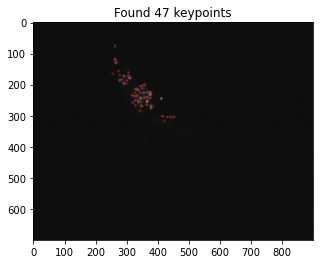

In [5]:
%matplotlib inline
plt.imshow(im_with_keypoints)
plt.title(f"Found {len(keypoints)} keypoints")

## 3d blob detection

In [6]:
from ipywidgets import interact
import open3d as o3d
from DLC_for_WBFM.utils.feature_detection.utils_features import build_feature_tree
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_cluster_labels
import pandas as pd

In [7]:
alpha = 0.15

f = lambda dat, which_slice : (alpha*dat[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')


num_slices = 33
with tifffile.TiffFile(vol0) as tif:
    dat = tif.asarray()

## Try to track via ICP on planes

In [8]:
# Build point clouds for each plane

all_keypoints_pcs = []
all_ims_with_kps = []

for i in range(num_slices):
#     print(f"{i} / {num_slices}")
    im1_raw = f(dat, i)
    kp, im1 = detect_blobs(im1_raw)
    # Add to make the format: ZXY
    kp_3d = np.array([np.hstack((i, row.pt)) for row in kp])
    
    pc = o3d.geometry.PointCloud()
    if len(kp_3d) > 0:
        pc.points = o3d.utility.Vector3dVector(kp_3d)

    all_keypoints_pcs.append(pc)

In [43]:
# Build correspondence between each pair of planes

all_icp = []
opt = {'max_correspondence_distance':4.0}
# opt = {'max_correspondence_distance':10.0, 
#        'corres':o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(5.0)}


for i in range(0, num_slices-1):
#     print(f"{i} / {num_slices}")
    this_pc = all_keypoints_pcs[i]
    next_pc = all_keypoints_pcs[i+1]
    
    reg = o3d.pipelines.registration.registration_icp(this_pc, next_pc, **opt)
#     reg = o3d.pipelines.registration.registration_ransac_based_on_correspondence(this_pc, next_pc, **opt)
    
    all_icp.append(reg)

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


## Build tracklets from the above matches

In [44]:
# From: http://www.open3d.org/docs/release/tutorial/pipelines/icp_registration.html
import copy
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_tracks_simple

def draw_registration_result(source, target, transformation, base=None):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([0, 1, 0])
    target_temp.paint_uniform_color([1, 0, 0])
    
    source_temp.transform(transformation)
    if base is not None:
        o3d.visualization.draw_geometries([base, source_temp, target_temp])
    else:
        o3d.visualization.draw_geometries([source_temp, target_temp])

In [45]:
full_pc = o3d.geometry.PointCloud()
for pc in all_keypoints_pcs:
#     pc.paint_uniform_color(np.random.rand(3,1))
#     print(len(pc.points))
    full_pc = full_pc + pc
full_pc.paint_uniform_color([0.5,0.5,0.5])

PointCloud with 1133 points.

In [46]:
# vis = o3d.visualization.Visualizer()
# vis.create_window()
# vis.add_geometry(full_pc)
# vis.get_render_option()
# vis.run()
# vis.destroy_window()

In [47]:
verbose = 1

# Use registration results to build a combined and colored pointcloud
# pc_ind_to_cluster = []
clust_df = pd.DataFrame(columns=['clust_ind', 'all_ind_local', 'all_ind_global','slice_ind','to_be_finished', 'not_finished'])#,
#                       dtype=object)


def create_new_track(i0, i1, next_clust_ind, clust_df,
                    this_point_cloud_offset,
                    next_point_cloud_offset,
                    which_slice):
    
    new_track = pd.DataFrame({'clust_ind':next_clust_ind, 
                              'all_ind_local':[[i0,i1]], 
                              'all_ind_global':[[this_point_cloud_offset+i0, i1_global]],
                              'slice_ind':[[which_slice, which_slice+1]],
                              'to_be_finished':False, 
                              'not_finished':True})
    clust_df = clust_df.append(new_track, ignore_index=True)
    print(f"Creating new track {next_clust_ind}")
    next_clust_ind = next_clust_ind + 1
    
    return next_clust_ind, clust_df


def extend_track(i1, i1_global, row, i, clust_df, which_slice):
    row['all_ind_local'].append(i1)
#     print("current local ind", row['all_ind_local'])
    clust_df.at[i,'all_ind_local'] = list(row['all_ind_local'])
    row['all_ind_global'].append(i1_global)
    clust_df.at[i,'all_ind_global'] = list(row['all_ind_global'])
    row['slice_ind'].append(which_slice+1)
    clust_df.at[i,'slice_ind'] = list(row['slice_ind'])
    clust_df.at[i,'to_be_finished'] = False
    
    clust_ind = row['clust_ind']
    tmp = len(row['all_ind_local'])
    print(f"Adding to track {clust_ind} (length {tmp})")
    
    return clust_df

ongoing_tracks = {}
next_clust_ind = 0

this_point_cloud_offset = 0
next_point_cloud_offset = 0

for i_match, reg in enumerate(all_icp):
#     print(f"{i} / {num_slices}")
    # Get transform to global coordinates
    this_pc = all_keypoints_pcs[i_match]
    next_pc = all_keypoints_pcs[i_match+1]
    next_point_cloud_offset = next_point_cloud_offset + len(this_pc.points)
    
    offsets = {'next_point_cloud_offset':next_point_cloud_offset,
               'this_point_cloud_offset':this_point_cloud_offset,
              'which_slice':i_match}
    
    pairs = np.asarray(reg.correspondence_set)
    # Initialize ALL as to-be-finished
    clust_df['to_be_finished'] = True
    
    for i0, i1 in pairs:
#         print(clust_df)
        i1_global = next_point_cloud_offset+i1
        # If no tracks, need special logic
        ind_to_check = clust_df['not_finished']
        if len(ind_to_check)==0:
            next_clust_ind, clust_df = create_new_track(i0, i1, next_clust_ind, clust_df, **offsets)
            continue
        # Add to previous track if possible
        for i, row in clust_df[ind_to_check].iterrows():
#             print(f"pair: {i0}, {i1}, trying cluster: {i}")
            if i0 == row['all_ind_local'][-1]:
                clust_df = extend_track(i1, i1_global, row, i, clust_df,i_match)
                break
        else:
            # Create new track
#             if i_match>1:
#                 error
            next_clust_ind, clust_df = create_new_track(i0, i1, next_clust_ind, clust_df, **offsets)
        
    # Finalize tracks that didn't get a new point this loop
    to_finish = clust_df['to_be_finished']
    if len(np.where(to_finish)[0]) > 0 and verbose >= 1:
        print(f"Finished tracks {np.where(to_finish)[0]}")
    clust_df.loc[to_finish,'not_finished'] = False
    
    if verbose >= 2 and len(pairs) > 0:
#         draw_registration_result(this_pc, next_pc, reg.transformation, base=None)
        visualize_tracks_simple(this_pc, next_pc, pairs)
    
    this_point_cloud_offset = next_point_cloud_offset
    
        

Creating new track 0
Adding to track 0 (length 3)
Adding to track 0 (length 4)
Adding to track 0 (length 5)
Adding to track 0 (length 6)
Creating new track 1
Adding to track 0 (length 7)
Creating new track 2
Adding to track 1 (length 3)
Creating new track 3
Adding to track 2 (length 3)
Adding to track 1 (length 4)
Adding to track 0 (length 8)
Adding to track 3 (length 3)
Adding to track 1 (length 5)
Adding to track 0 (length 9)
Adding to track 2 (length 4)
Creating new track 4
Creating new track 5
Creating new track 6
Creating new track 7
Creating new track 8
Adding to track 1 (length 6)
Adding to track 8 (length 3)
Finished tracks [3]
Creating new track 9
Creating new track 10
Creating new track 11
Adding to track 5 (length 3)
Adding to track 11 (length 3)
Creating new track 12
Creating new track 13
Creating new track 14
Adding to track 12 (length 3)
Adding to track 12 (length 4)
Adding to track 6 (length 3)
Creating new track 15
Adding to track 9 (length 3)
Adding to track 2 (length 

Creating new track 84
Creating new track 85
Adding to track 37 (length 7)
Adding to track 46 (length 5)
Adding to track 75 (length 3)
Adding to track 43 (length 6)
Creating new track 86
Adding to track 72 (length 3)
Adding to track 67 (length 4)
Adding to track 77 (length 3)
Creating new track 87
Adding to track 64 (length 5)
Creating new track 88
Adding to track 6 (length 12)
Adding to track 69 (length 3)
Adding to track 43 (length 7)
Adding to track 73 (length 3)
Adding to track 35 (length 7)
Creating new track 89
Adding to track 33 (length 9)
Adding to track 70 (length 3)
Adding to track 27 (length 9)
Adding to track 5 (length 12)
Adding to track 10 (length 11)
Creating new track 90
Adding to track 79 (length 3)
Adding to track 27 (length 10)
Adding to track 20 (length 10)
Finished tracks [ 0  1  2  3  4  7  8  9 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 28
 29 30 31 32 34 36 38 39 40 41 44 45 47 48 49 50 51 52 53 54 56 57 58 59
 60 61 62 63 65 66 68 74]
Adding to track 43 (lengt

Creating new track 152
Adding to track 111 (length 5)
Adding to track 104 (length 6)
Adding to track 139 (length 3)
Adding to track 128 (length 4)
Creating new track 153
Adding to track 125 (length 7)
Creating new track 154
Adding to track 118 (length 7)
Adding to track 106 (length 8)
Finished tracks [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  76  77  78  79  80  81  83  84  85  86  87  88  89  90  92  93  94
  95  96  97  98  99 100 101 102 107 108 110 112 113 114 116 119 120 121
 123 124 126 131 133 134 136]
Creating new track 155
Adding to track 135 (length 4)
Adding to track 115 (length 6)
Adding to track 117 (length 6)
Creating new track 156
Creating new track 157
Creating new track 158
Adding to track 132 (length 4)
Adding to trac

Adding to track 185 (length 4)
Adding to track 196 (length 3)
Adding to track 175 (length 7)
Adding to track 179 (length 5)
Adding to track 128 (length 10)
Adding to track 201 (length 3)
Adding to track 106 (length 16)
Adding to track 176 (length 7)
Adding to track 164 (length 6)
Adding to track 75 (length 18)
Adding to track 199 (length 4)
Adding to track 193 (length 3)
Adding to track 128 (length 11)
Adding to track 172 (length 5)
Adding to track 130 (length 11)
Adding to track 5 (length 27)
Adding to track 200 (length 3)
Creating new track 208
Adding to track 144 (length 8)
Adding to track 145 (length 10)
Adding to track 117 (length 15)
Adding to track 181 (length 4)
Finished tracks [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  76 

## Visualize the tracklets

In [48]:
# Assign colors to the data frame based on cluster id
max_label = clust_df['clust_ind'].max()
clust_df['colors'] = list(plt.get_cmap("tab20")(pd.to_numeric(clust_df.clust_ind, downcast='float') / max_label))
# clust_df['colors'] = list(plt.get_cmap()(pd.to_numeric(clust_df.clust_ind, downcast='float') / max_label))

# Add colors to actual point cloud
full_pc.paint_uniform_color([0,0,0])
final_colors = np.asarray(full_pc.colors)

for i, row in clust_df.iterrows():
    these_ind = row.all_ind_global
    if len(these_ind) < 3:
        continue
    this_color = row['colors']
    print(f"Color {this_color[:3]} for neurons {these_ind}")
    
    all_colors = np.vstack([this_color[:3] for i in these_ind])
    final_colors[these_ind,:] = all_colors

full_pc.colors = o3d.utility.Vector3dVector(final_colors)

Color [0.12156863 0.46666667 0.70588235] for neurons [68, 69, 70, 71, 72, 74, 78, 82, 115]
Color [0.12156863 0.46666667 0.70588235] for neurons [73, 76, 80, 85, 93, 92, 118, 174, 227]
Color [0.12156863 0.46666667 0.70588235] for neurons [77, 81, 84, 94, 121, 178, 172, 206, 193, 233, 238, 262, 273]
Color [0.12156863 0.46666667 0.70588235] for neurons [75, 79, 83]
Color [0.12156863 0.46666667 0.70588235] for neurons [91, 113, 143, 177, 207, 245, 250, 315, 373]
Color [0.12156863 0.46666667 0.70588235] for neurons [88, 103, 123, 126, 159, 208, 252, 300, 358, 421, 404, 447, 502, 495, 543, 550, 605, 602, 637, 683, 740, 812, 891, 861, 918, 990, 1058, 1104]
Color [0.12156863 0.46666667 0.70588235] for neurons [89, 98, 120, 154, 194, 191, 188, 236, 298, 348, 409, 471]
Color [0.12156863 0.46666667 0.70588235] for neurons [90, 101, 127, 158, 169, 222, 215, 253, 303, 319, 326, 383]
Color [0.12156863 0.46666667 0.70588235] for neurons [87, 96, 95, 117, 151, 190, 189]
Color [0.12156863 0.46666667 0.

In [49]:
o3d.visualization.draw_geometries([full_pc])

In [ ]:
full_pc.paint_uniform_color([0,0,0])
# o3d.visualization.draw_geometries([full_pc])
# Add colors to actual point cloud
full_pc.paint_uniform_color([0,0,0])
final_colors = np.asarray(full_pc.colors)

# these_ind = range(0,67) # First layer
# these_ind = [68, 69, 70, 71, 72, 74, 78, 82, 115] # A clean neuron
these_ind = clust_df['all_ind_global'][1]
this_color = [0,1,0,1]
print(f"Color {this_color[:3]} for neurons {these_ind}")

all_colors = np.vstack([this_color[:3] for i in these_ind])
final_colors[these_ind,:] = all_colors

full_pc.colors = o3d.utility.Vector3dVector(final_colors)

o3d.visualization.draw_geometries([full_pc])

In [ ]:
len(full_pc.points)

In [ ]:
print(clust_df['all_ind_global'][1])

In [ ]:
clust_df

# ===============================================================================
# OLD

### Alternate clustering tests

In [21]:
# def remove_outliers_from_2_clouds(this_pc, next_pc):
#     combined_pc = this_pc + next_pc
#     if len(this_pc.points) > 0 and len(next_pc.points) > 0:   
#         cl, ind = combined_pc.remove_radius_outlier(nb_points=1, radius=3.0)

#         cut = len(this_pc.points)
#         print(ind)

#         out1 = this_pc.select_by_index(ind[:cut])
#         out2 = next_pc.select_by_index(ind[cut:])
#     else:
#         print("Empty point cloud; removing no outliers")
    
#     return out1, out2

In [22]:
# Build correspondence between each pair of planes
# import copy

# all_icp = []
# opt = {'max_correspondence_distance':10.0}

# for i in range(10, num_slices-1):
# #     print(f"{i} / {num_slices}")
# #     this_pc = 
# #     next_pc = 
    
#     this_pc, next_pc = remove_outliers_from_2_clouds(copy.deepcopy(all_keypoints_pcs[i]), copy.deepcopy(all_keypoints_pcs[i+1]))
    
#     reg = o3d.pipelines.registration.registration_icp(this_pc, next_pc, **opt)
    
#     all_icp.append(reg)

In [23]:
# # Try correspondence via global registration, not ICP

# all_icp = []
# feature_opt = {'search_param':o3d.geometry.KDTreeSearchParamHybrid(radius=50.0, max_nn=10)}

# for i in range(10, num_slices-1):
# #     print(f"{i} / {num_slices}")
#     this_pc = all_keypoints_pcs[i]
#     next_pc = all_keypoints_pcs[i+1]
    
#     # Generate features
#     f1 = o3d.pipelines.registration.compute_fpfh_feature(this_pc, **feature_opt)
#     f2 = o3d.pipelines.registration.compute_fpfh_feature(next_pc, **feature_opt)
    
#     reg =  o3d.pipelines.registration.registration_ransac_based_on_feature_matching(this_pc, next_pc, f1, f2)
    
#     all_icp.append(reg)

## Simplest: find peaks

In [ ]:
from skimage.feature import peak_local_max

In [ ]:
# Background subtraction:
# https://docs.opencv.org/3.3.0/db/d5c/tutorial_py_bg_subtraction.html
# Peak detection:
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html

#im1 = np.abs(cv2.GaussianBlur(im1_raw,(3,3),0) - np.min(im1_raw))
im1 = cv2.GaussianBlur(im1_raw,(3,3),0)
fgbg = cv2.createBackgroundSubtractorKNN()
fgbg.apply(im1)

%matplotlib notebook
plt.imshow(im1)

thresh = np.mean(im1)+10
coordinates = peak_local_max(im1, min_distance=5, num_peaks=200, threshold_abs=thresh)

In [ ]:

plt.imshow(im1, cmap=plt.cm.gray)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

## Thresholds

In [ ]:
# Do some preprocessing
# From: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
# Otsu's thresholding
im1 = cv2.GaussianBlur(im1_raw,(5,5),0)
#ret2,im1 = cv2.threshold(im1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im1 = cv2.adaptiveThreshold(im1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

# Make neurons dark spts
#im1 = cv2.bitwise_not(im1)

In [ ]:
%matplotlib inline
plt.imshow(im1)

## Contours

In [ ]:
# Just find contours
%matplotlib inline
contours, hierarchy = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

im = np.expand_dims(im1, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    im = cv2.drawContours(im, contours, k, (0, 230, 255), 6)
plt.imshow(im)

## Try to track via clustering

In [ ]:

all_keypoints = []
all_ims_with_kps = []
    
for i in range(num_slices):
#     print(f"{i} / {num_slices}")
    im1_raw = f(dat, i)
    kp, im1 = detect_blobs(im1_raw)
    # Add to make the format: ZXY
    kp_3d = np.array([np.hstack((i, row.pt)) for row in kp])
    all_keypoints.extend(kp_3d)
    
    im_with_keypoints = cv2.drawKeypoints(im1, kp, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    all_ims_with_kps.append(im_with_keypoints)

all_keypoints = np.array(all_keypoints)

In [ ]:
def my_plot(i): 
    plt.imshow(all_ims_with_kps[i])
    plt.title(f"{i}")

In [ ]:
interact(my_plot, i=(0,num_slices-1))

In [ ]:

def combine_2d_blobs(all_keypoints, min_z_detections=3):
    """
    Assumes that a real neuron will be detected on more than one plane, and combines them
    """
    
#     all_xyz = all_keypoints[:].pt
    n, point_cloud, tree = build_feature_tree(all_keypoints)
    
    return point_cloud

In [ ]:
pc = combine_2d_blobs(all_keypoints)

In [ ]:
#o3d.visualization.draw_geometries([pc])

In [ ]:
# from sklearn.cluster import SpectralClustering
# opt = {'n_neighbors':2,
#        'n_clusters':150}
# clusterer = SpectralClustering(**opt)

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# opt = {'distance_threshold':2.0,
#        'compute_full_tree':True,
#        'linkage':'single',
#        'n_clusters':None}
# clusterer = AgglomerativeClustering(**opt)

In [ ]:
from sklearn.cluster import OPTICS
opt = {'min_samples':2,
       'max_eps':3.0}
clusterer = OPTICS(**opt)

In [ ]:
labels = clusterer.fit_predict(pc.points)

In [ ]:
visualize_cluster_labels(labels, pc)

## Simple test: dbscan

In [ ]:
labels = np.array(pc.cluster_dbscan(eps=1.5, min_points=3))

In [ ]:
visualize_cluster_labels(labels, pc)